In [21]:
# =========================
# CORE / DATA HANDLING
# =========================
import numpy as np
import pandas as pd

# =========================
# COLAB / I/O
# =========================
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [22]:
df = pd.read_csv("/content/drive/MyDrive/clean_amazon_reviews_text.csv")
df_feat = pd.read_csv("/content/drive/MyDrive/clean_amazon_reviews_feat.csv")


In [23]:
print(df.shape)
print(df_feat.shape)

(277075, 2)
(277075, 4)


In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 277075 entries, 0 to 277074
Data columns (total 2 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Text_clean  277075 non-null  object
 1   sentiment   277075 non-null  object
dtypes: object(2)
memory usage: 4.2+ MB


In [25]:
df_feat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 277075 entries, 0 to 277074
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Text_clean  277075 non-null  object
 1   sentiment   277075 non-null  object
 2   word_count  277075 non-null  int64 
 3   text_len    277075 non-null  int64 
dtypes: int64(2), object(2)
memory usage: 8.5+ MB


---
---
---

Using a smaller sample to train the data, as full dataset will take too long.

In [26]:
df = (
    df
    .groupby("sentiment", group_keys=False)
    .apply(lambda x: x.sample(frac=0.05, random_state=42))
    .reset_index(drop=True)
)

/tmp/ipython-input-1756638874.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.sample(frac=0.05, random_state=42))


In [27]:
df.shape

(13854, 2)

In [28]:
df_feat = (
    df_feat
    .groupby("sentiment", group_keys=False)
    .apply(lambda x: x.sample(frac=0.05, random_state=42))
    .reset_index(drop=True)
)

/tmp/ipython-input-3293690430.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.sample(frac=0.05, random_state=42))


In [29]:
df_feat.shape

(13854, 4)

---
---
---
# Helpers (functions for models)

In [30]:
# Shared helpers for all models (evaluation, grids, saving)
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.base import clone
from sklearn.metrics import (
    f1_score, classification_report, confusion_matrix,
    roc_auc_score, average_precision_score
)
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score, make_scorer

#### OOF generator: trains a clone per fold and returns OOF predictions/scores + per-fold macro-F1 ---

In [31]:
def get_oof(estimator, X, y, cv, *, fit_kwargs=None, score_kind="proba"):
    """
    Build Out-Of-Fold (OOF) predictions for fair, leak-free evaluation.
    - estimator: a sklearn Pipeline (e.g., TF-IDF + classifier)
    - X, y: pandas Series/DataFrame
    - cv: a StratifiedKFold splitter
    - fit_kwargs: dict -> kwargs passed to .fit (e.g., {'clf__sample_weight': weights})
    - score_kind: 'proba' (predict_proba[:,1]) or 'decision' (decision_function)
    Returns: oof_pred (str labels), oof_score (float), fold_f1 (np.array of macro-F1 per fold)
    """
    oof_pred  = np.empty_like(y, dtype=object)
    oof_score = np.empty(len(y), dtype=float)
    fold_f1   = []

    for tr, te in cv.split(X, y):
        est = clone(estimator)
        kw  = fit_kwargs or {}
        est.fit(X.iloc[tr], y.iloc[tr], **kw)
        # test-fold outputs
        y_hat = est.predict(X.iloc[te])
        if score_kind == "proba":
            s = est.predict_proba(X.iloc[te])[:, 1]
        else:
            s = est.decision_function(X.iloc[te])

        oof_pred[te]  = y_hat
        oof_score[te] = s
        fold_f1.append(f1_score(y.iloc[te], y_hat, average="macro"))

    return oof_pred, oof_score, np.array(fold_f1)

#### Evaluation printer: report + CM + AUCs (PR-AUC for pos & neg)

In [32]:
def eval_oof(y_true, y_pred, y_score, *, model_name="", score_kind="proba", cm_cmap="Blues"):
    """
    Prints classification_report, plots confusion matrix, and prints ROC-AUC + PR-AUC(pos/neg).
    score_kind controls how PR-AUC(neg) is computed: proba -> (1 - proba); decision -> (-score).
    Returns: dict of summary metrics.
    """
    print(f"\nOOF classification report — {model_name}\n")
    print(classification_report(y_true, y_pred, digits=4))

    cm = confusion_matrix(y_true, y_pred, labels=["negative","positive"])
    sns.heatmap(cm, annot=True, fmt="d", cmap=cm_cmap,
                xticklabels=["negative","positive"], yticklabels=["negative","positive"])
    plt.title(f"OOF Confusion Matrix — {model_name}")
    plt.xlabel("Predicted"); plt.ylabel("True"); plt.show()

    y_pos = (y_true == "positive").astype(int)
    y_neg = (y_true == "negative").astype(int)

    roc = roc_auc_score(y_pos, y_score)
    pr_pos = average_precision_score(y_pos, y_score)
    neg_input = (1 - y_score) if score_kind == "proba" else (-y_score)
    pr_neg = average_precision_score(y_neg, neg_input)

    print(f"ROC-AUC (positive):  {roc:.4f}")
    print(f"PR-AUC  (positive): {pr_pos:.4f}")
    print(f"PR-AUC  (negative): {pr_neg:.4f}")

    return {"model": model_name, "roc_auc": roc, "pr_auc_pos": pr_pos, "pr_auc_neg": pr_neg}

#### GridSearch helper: small table out, best estimator back

In [33]:
SCORER = make_scorer(f1_score, average="macro")

def run_grid(estimator, param_grid, X, y, *, cv, fit_kwargs=None, verbose=1):
    """
    Uniform grid search runner (macro-F1). Returns:
    (best_estimator, best_score, best_params, results_df)
    """
    gs = GridSearchCV(
        estimator=estimator,
        param_grid=param_grid,
        scoring="f1_macro",      # <- enforce macro-F1 (avoids pos_label=1 issue with string labels)
        cv=cv,
        n_jobs=-1,
        verbose=verbose,
        refit=True,
        error_score="raise"      # <- keep while fixing; remove later if you prefer NaNs
    )

    if fit_kwargs:
        gs.fit(X, y, **fit_kwargs)
    else:
        gs.fit(X, y)

    best = gs.best_estimator_
    res = (pd.DataFrame(gs.cv_results_)
           .sort_values("mean_test_score", ascending=False))
    view_cols = ["mean_test_score","std_test_score","mean_fit_time"] + \
                [c for c in res.columns if c.startswith("param_")]
    return best, gs.best_score_, gs.best_params_, res[view_cols].head(10)

#### Save helper

In [34]:
import joblib
def save_model(estimator, path):
    joblib.dump(estimator, path)
    print("Saved:", path)

---
---
---
# Shared config, CV, and data bindings

In [35]:
# Shared config, CV, and data bindings
RANDOM_STATE = 42

from sklearn.model_selection import StratifiedKFold
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

# Expect these columns to exist from your EDA notebook
X = df["Text_clean"]
y = df["sentiment"]

# Common TF-IDF defaults applied across models for fairness
from sklearn.feature_extraction.text import TfidfVectorizer
TFIDF_DEFAULTS = dict(
    ngram_range=(1,2),
    max_features=10_000,  # you can set 20_000 later; start lean for speed
    min_df=5,
    sublinear_tf=True,
    stop_words="english"
)


---
---
---
# Models

---
### 1 -  TF-IDF + Logistic Regression

In [36]:
# Logistic (TF-IDF + LogisticRegression) factory
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression

def make_logreg():
    return Pipeline([
        ("tfidf", TfidfVectorizer(**TFIDF_DEFAULTS)),
        ("clf", LogisticRegression(
            class_weight="balanced",   # imbalance handled in loss
            solver="saga",             # fast & robust on sparse high-dim
            max_iter=300,
            n_jobs=1,                  # avoid nested parallelism
            random_state=RANDOM_STATE
        ))
    ])

CV macro-F1 (per-fold + mean±std)

In [37]:
from sklearn.model_selection import cross_val_score

pipe_lr = make_logreg()

cv_scores = cross_val_score(
    pipe_lr, X, y, cv=cv, scoring="f1_macro", n_jobs=-1
)
print("CV macro-F1 per fold:", np.round(cv_scores, 4))
print("CV macro-F1 mean±std:", np.round(cv_scores.mean(), 4), "±", np.round(cv_scores.std(), 4))

CV macro-F1 per fold: [0.8526 0.8372 0.8417 0.8391 0.8367]
CV macro-F1 mean±std: 0.8415 ± 0.0058


OOF evaluation (report, CM heatmap, ROC-AUC, PR-AUC pos & neg)

OOF macro-F1 per fold (from OOF loop): [0.8526 0.8372 0.8417 0.8391 0.8367]
OOF macro-F1 mean±std: 0.8415 ± 0.0058

OOF classification report — Logistic (TF-IDF)

              precision    recall  f1-score   support

    negative     0.6540    0.8228    0.7288      1778
    positive     0.9729    0.9359    0.9540     12076

    accuracy                         0.9214     13854
   macro avg     0.8134    0.8794    0.8414     13854
weighted avg     0.9320    0.9214    0.9251     13854



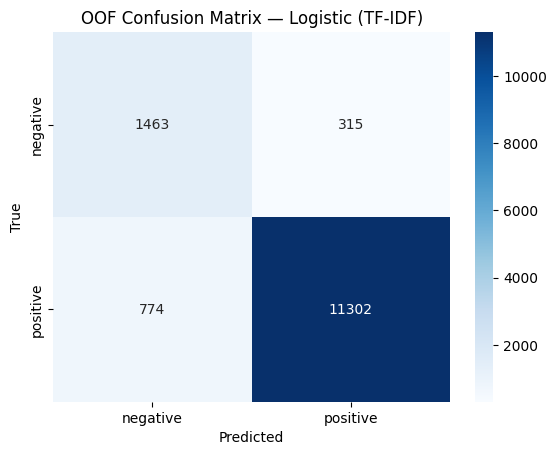

ROC-AUC (positive):  0.9569
PR-AUC  (positive): 0.9927
PR-AUC  (negative): 0.8231


In [38]:
pipe_lr = make_logreg()

oof_pred, oof_score, fold_f1 = get_oof(
    pipe_lr, X, y, cv, score_kind="proba"   # Logistic has predict_proba
)

print("OOF macro-F1 per fold (from OOF loop):", np.round(fold_f1, 4))
print("OOF macro-F1 mean±std:", np.round(fold_f1.mean(),4), "±", np.round(fold_f1.std(),4))

summary_lr = eval_oof(
    y_true=y, y_pred=oof_pred, y_score=oof_score,
    model_name="Logistic (TF-IDF)",
    score_kind="proba",
    cm_cmap="Blues"
)

Hyper-parameter search (lean grid) + results table

In [20]:
grid_lr = {
    # TF-IDF (safe on small folds)
    "tfidf__max_features": [10_000, 20_000],
    "tfidf__ngram_range": [(1,1), (1,2)],
    "tfidf__min_df": [1, 2],
    "tfidf__strip_accents": ["unicode"],
    "tfidf__token_pattern": [r"(?u)\b[a-zA-Z]{3,}\b"],

    # Logistic
    "clf__C": [0.5, 1.0, 2.0],
    "clf__solver": ["saga"],
    "clf__n_jobs": [1],      # avoid nested parallelism
}

best_lr, best_lr_score, best_lr_params, grid_view_lr = run_grid(
    make_logreg(), grid_lr, X, y, cv=cv, verbose=1
)
print("Best CV macro-F1:", round(best_lr_score, 4))
print("Best params:", best_lr_params)
print("\n\n")

# Only show columns that add value
show_cols_lr = [
    "mean_test_score", "std_test_score", "mean_fit_time",
    "param_clf__C",
    "param_tfidf__max_features", "param_tfidf__min_df", "param_tfidf__ngram_range",
]

display(grid_view_lr[show_cols_lr].head(10))

Fitting 5 folds for each of 24 candidates, totalling 120 fits
Best CV macro-F1: 0.8529
Best params: {'clf__C': 2.0, 'clf__n_jobs': 1, 'clf__solver': 'saga', 'tfidf__max_features': 20000, 'tfidf__min_df': 2, 'tfidf__ngram_range': (1, 2), 'tfidf__strip_accents': 'unicode', 'tfidf__token_pattern': '(?u)\\b[a-zA-Z]{3,}\\b'}





,mean_test_score,std_test_score,mean_fit_time,param_clf__C,param_tfidf__max_features,param_tfidf__min_df,param_tfidf__ngram_range
23,0.852915,0.006250,5.976675,2.0,20000,2,"(1, 2)"
21,0.851850,0.006219,4.774674,2.0,20000,1,"(1, 2)"
19,0.846898,0.006909,4.739989,2.0,10000,2,"(1, 2)"
17,0.846328,0.007322,4.798697,2.0,10000,1,"(1, 2)"
13,0.844649,0.005463,4.785351,1.0,20000,1,"(1, 2)"
15,0.844391,0.006798,4.825085,1.0,20000,2,"(1, 2)"
11,0.841924,0.006076,4.612303,1.0,10000,2,"(1, 2)"
9,0.841525,0.006129,4.513343,1.0,10000,1,"(1, 2)"
20,0.840055,0.012893,2.528449,2.0,20000,1,"(1, 1)"
22,0.839723,0.012110,2.836336,2.0,20000,2,"(1, 1)"


Save the tuned pipeline

In [39]:
save_model(best_lr, "logreg_tfidf_cv_best.joblib")

Saved: logreg_tfidf_cv_best.joblib


---
### 2 - TF-IDF + LinearSVC

In [40]:
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.feature_extraction.text import TfidfVectorizer

def make_svm():
    return Pipeline([
        ("tfidf", TfidfVectorizer(**TFIDF_DEFAULTS)),
        ("clf", LinearSVC(
            C=1.0,
            class_weight="balanced",
            loss="squared_hinge",
            penalty="l2",
            dual=False,          # better for n_samples > n_features (with l2)
            max_iter=3000,
            random_state=RANDOM_STATE
        ))
    ])

CV macro-F1 (per-fold + mean±std)

In [41]:
from sklearn.model_selection import cross_val_score
import numpy as np

pipe_svm = make_svm()

cv_scores = cross_val_score(
    pipe_svm, X, y, cv=cv, scoring="f1_macro", n_jobs=-1
)
print("CV macro-F1 per fold:", np.round(cv_scores, 4))
print("CV macro-F1 mean±std:", np.round(cv_scores.mean(), 4), "±", np.round(cv_scores.std(), 4))

CV macro-F1 per fold: [0.8491 0.8387 0.8605 0.8579 0.8381]
CV macro-F1 mean±std: 0.8489 ± 0.0094


OOF evaluation (report, CM heatmap, ROC-AUC, PR-AUC pos & neg)

OOF macro-F1 per fold (from OOF loop): [0.8491 0.8387 0.8605 0.8579 0.8381]
OOF macro-F1 mean±std: 0.8489 ± 0.0094

OOF classification report — LinearSVC (TF-IDF)

              precision    recall  f1-score   support

    negative     0.7193    0.7565    0.7374      1778
    positive     0.9639    0.9565    0.9602     12076

    accuracy                         0.9309     13854
   macro avg     0.8416    0.8565    0.8488     13854
weighted avg     0.9325    0.9309    0.9316     13854



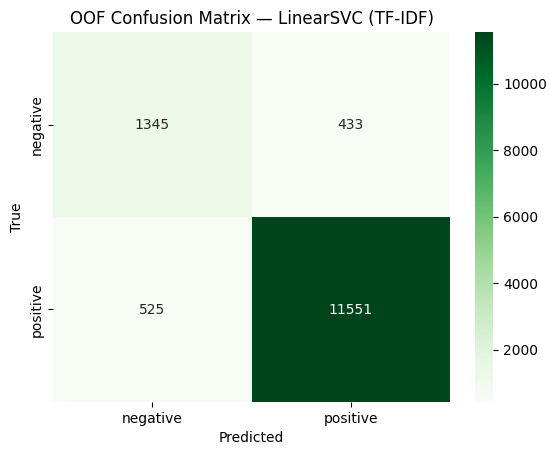

ROC-AUC (positive):  0.9519
PR-AUC  (positive): 0.9917
PR-AUC  (negative): 0.8143


In [42]:
pipe_svm = make_svm()

oof_pred, oof_score, fold_f1 = get_oof(
    pipe_svm, X, y, cv, score_kind="decision"   # LinearSVC => decision scores
)

print("OOF macro-F1 per fold (from OOF loop):", np.round(fold_f1, 4))
print("OOF macro-F1 mean±std:", np.round(fold_f1.mean(),4), "±", np.round(fold_f1.std(),4))

summary_svm = eval_oof(
    y_true=y, y_pred=oof_pred, y_score=oof_score,
    model_name="LinearSVC (TF-IDF)",
    score_kind="decision",      # eval helper will use -score for PR-AUC(neg)
    cm_cmap="Greens"
)

Hyper-parameter search (lean grid) + results table

In [43]:
grid_svm = {
    # TF-IDF
    "tfidf__max_features": [10_000, 20_000],
    "tfidf__ngram_range": [(1,1), (1,2)],
    "tfidf__min_df": [1, 2],
    "tfidf__strip_accents": ["unicode"],
    "tfidf__token_pattern": [r"(?u)\b[a-zA-Z]{3,}\b"],

    # LinearSVC
    "clf__C": [0.5, 1.0, 2.0],
    # keep stable fixed choices:
    "clf__loss": ["squared_hinge"],
    "clf__penalty": ["l2"],
    "clf__dual": [False],
    "clf__class_weight": ["balanced"],
    "clf__max_iter": [3000],
}

best_svm, best_svm_score, best_svm_params, grid_view_svm = run_grid(
    make_svm(), grid_svm, X, y, cv=cv, verbose=1
)
print("Best CV macro-F1:", round(best_svm_score, 4))
print("Best params:", best_svm_params)
print("\n\n")

show_cols_lr = [
    "mean_test_score","std_test_score","mean_fit_time",
    "param_clf__C",
    "param_tfidf__max_features","param_tfidf__min_df","param_tfidf__ngram_range",
]

display(grid_view_svm[show_cols_lr].head(10))

Fitting 5 folds for each of 24 candidates, totalling 120 fits
Best CV macro-F1: 0.856
Best params: {'clf__C': 0.5, 'clf__class_weight': 'balanced', 'clf__dual': False, 'clf__loss': 'squared_hinge', 'clf__max_iter': 3000, 'clf__penalty': 'l2', 'tfidf__max_features': 20000, 'tfidf__min_df': 2, 'tfidf__ngram_range': (1, 2), 'tfidf__strip_accents': 'unicode', 'tfidf__token_pattern': '(?u)\\b[a-zA-Z]{3,}\\b'}





,mean_test_score,std_test_score,mean_fit_time,param_clf__C,param_tfidf__max_features,param_tfidf__min_df,param_tfidf__ngram_range
7,0.856024,0.004952,3.891761,0.5,20000,2,"(1, 2)"
5,0.855693,0.005158,3.875140,0.5,20000,1,"(1, 2)"
13,0.851467,0.005627,4.023608,1.0,20000,1,"(1, 2)"
1,0.851333,0.008619,3.937081,0.5,10000,1,"(1, 2)"
15,0.850186,0.004364,3.972846,1.0,20000,2,"(1, 2)"
3,0.849013,0.007529,3.826201,0.5,10000,2,"(1, 2)"
21,0.848775,0.005299,3.811568,2.0,20000,1,"(1, 2)"
23,0.848439,0.004649,3.468887,2.0,20000,2,"(1, 2)"
11,0.847291,0.009764,3.877897,1.0,10000,2,"(1, 2)"
9,0.846919,0.009854,3.909169,1.0,10000,1,"(1, 2)"


SVM doesn’t output probabilities, we use decision scores for ROC/PR; PR-AUC(neg) is computed with −score.

Save the tuned SVM pipeline

In [44]:
save_model(best_svm, "linearsvc_tfidf_cv_best.joblib")

Saved: linearsvc_tfidf_cv_best.joblib


---
### 3 – ColumnTransformer model (text + numeric helpers)

In [45]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer

In [46]:
# Expect df_feat to have: ["Text_clean", "word_count", "text_len", "sentiment"]

#assert all(c in df_feat.columns for c in ["Text_clean","word_count","text_len","sentiment"]), \
#    "df_feat must contain Text_clean, word_count, text_len, sentiment"

# 1) Column names (reuse across this model)
TEXT_COL = "Text_clean"
NUM_COLS = ["word_count", "text_len"]

# 2) Bind features/labels from df_feat
X_ct = df_feat[[TEXT_COL, *NUM_COLS]].copy()
y_ct = df_feat["sentiment"].copy()
print("X_ct columns:", list(X_ct.columns))
print("y_ct distribution:\n", y_ct.value_counts(normalize=True).round(3))

X_ct columns: ['Text_clean', 'word_count', 'text_len']
y_ct distribution:
 sentiment
positive    0.872
negative    0.128
Name: proportion, dtype: float64


In [47]:
# 3) Factory for the ColumnTransformer + LogisticRegression pipeline
def make_coltx_lr():
    pre = ColumnTransformer(
        transformers=[
            ("text", TfidfVectorizer(**TFIDF_DEFAULTS), TEXT_COL),
            ("num", StandardScaler(), NUM_COLS),
        ],
        verbose_feature_names_out=False,
        remainder="drop"
    )
    return Pipeline([
        ("pre", pre),
        ("clf", LogisticRegression(
            class_weight="balanced",
            solver="saga",
            max_iter=400,
            n_jobs=1,                 # avoid nested parallelism
            random_state=RANDOM_STATE
        ))
    ])

CV macro-F1 (per-fold + mean±std)

In [48]:
from sklearn.model_selection import cross_val_score
import numpy as np

pipe_ct_lr = make_coltx_lr()

cv_scores = cross_val_score(
    pipe_ct_lr, X_ct, y_ct, cv=cv, scoring="f1_macro", n_jobs=-1
)
print("CV macro-F1 per fold:", np.round(cv_scores, 4))
print("CV macro-F1 mean±std:", np.round(cv_scores.mean(), 4), "±", np.round(cv_scores.std(), 4))

CV macro-F1 per fold: [0.8529 0.8347 0.8407 0.8433 0.8337]
CV macro-F1 mean±std: 0.8411 ± 0.0069


OOF evaluation (report, CM heatmap, ROC-AUC, PR-AUC pos/neg)

OOF macro-F1 per fold (from OOF loop): [0.8529 0.8347 0.8407 0.8433 0.8337]
OOF macro-F1 mean±std: 0.8411 ± 0.0069

OOF classification report — ColumnTransformer (TF-IDF text + numeric) + LR

              precision    recall  f1-score   support

    negative     0.6507    0.8268    0.7283      1778
    positive     0.9734    0.9347    0.9537     12076

    accuracy                         0.9208     13854
   macro avg     0.8121    0.8807    0.8410     13854
weighted avg     0.9320    0.9208    0.9247     13854



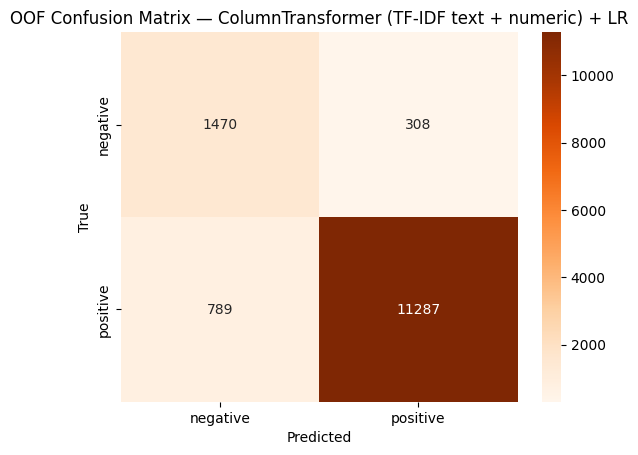

ROC-AUC (positive):  0.9565
PR-AUC  (positive): 0.9926
PR-AUC  (negative): 0.8231


In [49]:
pipe_ct_lr = make_coltx_lr()

oof_pred, oof_score, fold_f1 = get_oof(
    pipe_ct_lr, X_ct, y_ct, cv, score_kind="proba"   # Logistic → predict_proba
)

print("OOF macro-F1 per fold (from OOF loop):", np.round(fold_f1, 4))
print("OOF macro-F1 mean±std:", np.round(fold_f1.mean(),4), "±", np.round(fold_f1.std(),4))

summary_ct = eval_oof(
    y_true=y_ct, y_pred=oof_pred, y_score=oof_score,
    model_name="ColumnTransformer (TF-IDF text + numeric) + LR",
    score_kind="proba",
    cm_cmap="Oranges"
)

Hyper-parameter search (lean) + results table

In [50]:
grid_ct = {
    # Text branch (note path through ColumnTransformer)
    "pre__text__max_features": [10_000, 20_000],
    "pre__text__ngram_range": [(1,1), (1,2)],
    "pre__text__min_df": [1, 2],
    "pre__text__strip_accents": ["unicode"],
    "pre__text__token_pattern": [r"(?u)\b[a-zA-Z]{3,}\b"],

    # Classifier
    "clf__C": [0.5, 1.0, 2.0],
    "clf__solver": ["saga"],
    "clf__n_jobs": [1],
}

best_ct, best_ct_score, best_ct_params, grid_view_ct = run_grid(
    make_coltx_lr(), grid_ct, X_ct, y_ct, cv=cv, verbose=1
)
print("Best CV macro-F1:", round(best_ct_score, 4))
print("Best params:", best_ct_params)
print("\n\n")

show_cols_ct = [
    "mean_test_score","std_test_score","mean_fit_time",
    "param_clf__C",
    "param_pre__text__max_features","param_pre__text__min_df","param_pre__text__ngram_range",
]
display(grid_view_ct[show_cols_ct].head(10))

Fitting 5 folds for each of 24 candidates, totalling 120 fits
Best CV macro-F1: 0.8487
Best params: {'clf__C': 2.0, 'clf__n_jobs': 1, 'clf__solver': 'saga', 'pre__text__max_features': 20000, 'pre__text__min_df': 2, 'pre__text__ngram_range': (1, 2), 'pre__text__strip_accents': 'unicode', 'pre__text__token_pattern': '(?u)\\b[a-zA-Z]{3,}\\b'}





/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


,mean_test_score,std_test_score,mean_fit_time,param_clf__C,param_pre__text__max_features,param_pre__text__min_df,param_pre__text__ngram_range
23,0.848749,0.005265,12.451261,2.0,20000,2,"(1, 2)"
21,0.848474,0.005815,13.679758,2.0,20000,1,"(1, 2)"
19,0.844985,0.006424,12.202920,2.0,10000,2,"(1, 2)"
17,0.844280,0.006043,12.926855,2.0,10000,1,"(1, 2)"
15,0.842300,0.006903,12.335553,1.0,20000,2,"(1, 2)"
13,0.841889,0.007208,11.790544,1.0,20000,1,"(1, 2)"
11,0.839406,0.007492,11.170346,1.0,10000,2,"(1, 2)"
9,0.838957,0.007160,11.074508,1.0,10000,1,"(1, 2)"
20,0.837950,0.007675,9.989476,2.0,20000,1,"(1, 1)"
18,0.837376,0.009704,9.348675,2.0,10000,2,"(1, 1)"


Save the tuned ColumnTransformer pipeline

In [51]:
save_model(best_ct, "coltx_tfidf_num_logreg_cv_best.joblib")

Saved: coltx_tfidf_num_logreg_cv_best.joblib


---
### 4 – TF-IDF → TruncatedSVD (≈300) → MLPClassifier (scikit-learn)

In [52]:
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.under_sampling import RandomUnderSampler
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier

MLP doesn’t support class_weight=; we use sample weights in every fit.

In [53]:
# ===== Data & weights for MLP =====
X_mlp = df["Text_clean"]
y_mlp = df["sentiment"]

from sklearn.utils.class_weight import compute_class_weight
import numpy as np

CLASSES = np.array(["negative","positive"])
CLASS_WEIGHT = compute_class_weight(class_weight="balanced", classes=CLASSES, y=y_mlp)
W_MAP = dict(zip(CLASSES, CLASS_WEIGHT))
SAMPLE_WEIGHTS = y_mlp.map(W_MAP).values  # 1D array aligned with y_mlp

print("Class weights:", W_MAP)
print("y distribution:\n", y_mlp.value_counts(normalize=True).round(3))

Class weights: {np.str_('negative'): np.float64(3.895950506186727), np.str_('positive'): np.float64(0.5736170917522359)}
y distribution:
 sentiment
positive    0.872
negative    0.128
Name: proportion, dtype: float64


Model factory (TF-IDF → SVD → Scaler → MLP)

In [54]:
def make_mlp(n_components=300, hls=(256,), alpha=1e-4, sampling_strategy=1.0):
    """
    TF-IDF -> SVD -> Scaler -> RandomUnderSampler -> MLP (no early_stopping to avoid dtype issues)
    """
    return ImbPipeline([
        ("tfidf",  TfidfVectorizer(**TFIDF_DEFAULTS)),
        ("svd",    TruncatedSVD(n_components=n_components, random_state=RANDOM_STATE)),
        ("scaler", StandardScaler(with_mean=True)),
        ("sampler", RandomUnderSampler(sampling_strategy=sampling_strategy, random_state=RANDOM_STATE)),
        ("clf",    MLPClassifier(
            hidden_layer_sizes=hls,
            activation="relu",
            alpha=alpha,                 # L2 regularization
            learning_rate_init=1e-3,
            early_stopping=False,        # <-- changed
            max_iter=150,                # a bit higher since no early stopping
            n_iter_no_change=10,         # harmless if early_stopping=False
            random_state=RANDOM_STATE
        ))
    ])

CV macro-F1 (per-fold + mean±std)

In [55]:
pipe_mlp = make_mlp(n_components=300, hls=(256,), alpha=1e-4, sampling_strategy=1.0)

oof_pred_mlp, oof_score_mlp, fold_f1_mlp = get_oof(
    estimator=pipe_mlp,
    X=X_mlp, y=y_mlp,
    cv=cv,
    score_kind="proba"   # MLP has predict_proba
)

print("CV macro-F1 per fold:", np.round(fold_f1_mlp, 4))
print("CV macro-F1 mean±std:", np.round(fold_f1_mlp.mean(), 4), "±", np.round(fold_f1_mlp.std(), 4))

CV macro-F1 per fold: [0.7509 0.7518 0.7443 0.7521 0.7458]
CV macro-F1 mean±std: 0.749 ± 0.0033


OOF evaluation (report, CM heatmap, ROC-AUC, PR-AUC pos/neg)


OOF classification report — TF-IDF → SVD → MLP

              precision    recall  f1-score   support

    negative     0.4499    0.8661    0.5922      1778
    positive     0.9772    0.8441    0.9058     12076

    accuracy                         0.8469     13854
   macro avg     0.7135    0.8551    0.7490     13854
weighted avg     0.9095    0.8469    0.8655     13854



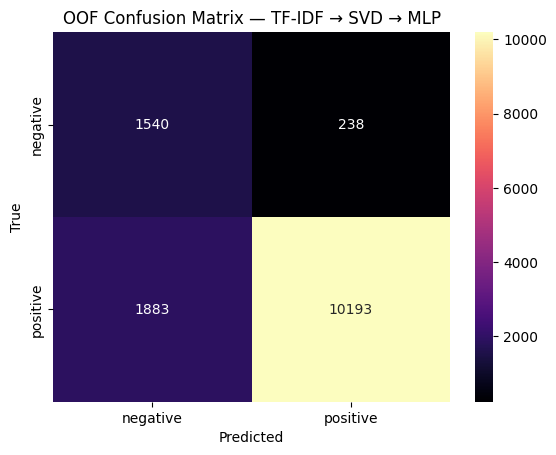

ROC-AUC (positive):  0.9292
PR-AUC  (positive): 0.9871
PR-AUC  (negative): 0.7423


In [56]:
summary_mlp = eval_oof(
    y_true=y_mlp, y_pred=oof_pred_mlp, y_score=oof_score_mlp,
    model_name="TF-IDF → SVD → MLP",
    score_kind="proba",
    cm_cmap="magma"
)

Grid search (no weights needed; sampler handles imbalance)

In [57]:
from sklearn.model_selection import StratifiedKFold
cv_grid_fast = StratifiedKFold(n_splits=3, shuffle=True, random_state=RANDOM_STATE)  # faster for grids

grid_mlp = {
    # TF-IDF (keep fixed-ish to limit search time; still safe)
    "tfidf__max_features": [20_000],
    "tfidf__ngram_range": [(1,2)],
    "tfidf__min_df": [1],   # safer on small folds
    "tfidf__strip_accents": ["unicode"],
    "tfidf__token_pattern": [r"(?u)\b[a-zA-Z]{3,}\b"],

    # SVD dimensionality
    "svd__n_components": [200, 300, 400],

    # Sampler (imbalance control)
    "sampler__sampling_strategy": [1.0],  # 1:1 in each training fold

    # MLP
    "clf__hidden_layer_sizes": [(256,), (256,128)],
    "clf__alpha": [1e-4, 1e-3],
    "clf__learning_rate_init": [1e-3],
    "clf__max_iter": [150],
}

best_mlp, best_mlp_score, best_mlp_params, grid_view_mlp = run_grid(
    make_mlp(), grid_mlp, X_mlp, y_mlp,
    cv=cv_grid_fast,   # faster during search; you still report 5-fold OOF
    verbose=1
)
print("Best CV macro-F1 (3-fold):", round(best_mlp_score, 4))
print("Best params:", best_mlp_params)
print("\n\n")

show_cols_mlp = [
    "mean_test_score","std_test_score","mean_fit_time",
    "param_svd__n_components",
    "param_clf__hidden_layer_sizes","param_clf__alpha",
    "param_tfidf__max_features","param_tfidf__min_df","param_tfidf__ngram_range",
    # "param_sampler__sampling_strategy",  # include if you tuned it
]
display(grid_view_mlp[show_cols_mlp].head(10))

Fitting 3 folds for each of 12 candidates, totalling 36 fits
Best CV macro-F1 (3-fold): 0.7519
Best params: {'clf__alpha': 0.001, 'clf__hidden_layer_sizes': (256,), 'clf__learning_rate_init': 0.001, 'clf__max_iter': 150, 'sampler__sampling_strategy': 1.0, 'svd__n_components': 200, 'tfidf__max_features': 20000, 'tfidf__min_df': 1, 'tfidf__ngram_range': (1, 2), 'tfidf__strip_accents': 'unicode', 'tfidf__token_pattern': '(?u)\\b[a-zA-Z]{3,}\\b'}





,mean_test_score,std_test_score,mean_fit_time,param_svd__n_components,param_clf__hidden_layer_sizes,param_clf__alpha,param_tfidf__max_features,param_tfidf__min_df,param_tfidf__ngram_range
6,0.751880,0.003022,15.196847,200,"(256,)",0.0010,20000,1,"(1, 2)"
0,0.751486,0.003232,15.916930,200,"(256,)",0.0001,20000,1,"(1, 2)"
1,0.750388,0.005934,20.339762,300,"(256,)",0.0001,20000,1,"(1, 2)"
7,0.750304,0.005865,19.445155,300,"(256,)",0.0010,20000,1,"(1, 2)"
8,0.742900,0.006371,24.967192,400,"(256,)",0.0010,20000,1,"(1, 2)"
2,0.742514,0.006917,24.689437,400,"(256,)",0.0001,20000,1,"(1, 2)"
11,0.742360,0.002581,22.539826,400,"(256, 128)",0.0010,20000,1,"(1, 2)"
5,0.742220,0.003221,23.987432,400,"(256, 128)",0.0001,20000,1,"(1, 2)"
3,0.740842,0.005102,15.168650,200,"(256, 128)",0.0001,20000,1,"(1, 2)"
4,0.740805,0.005301,18.726997,300,"(256, 128)",0.0001,20000,1,"(1, 2)"


Save the tuned MLP pipeline

In [58]:
save_model(best_mlp, "tfidf_svd_mlp_cv_best.joblib")

Saved: tfidf_svd_mlp_cv_best.joblib
